# Metadata processing
A notebook to process the metadata of the Bern cohort WSIs

## Import libraries and load data

In [1]:
import Abed_utils

import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from scipy.stats import ttest_ind, ttest_rel
from tqdm import tqdm

In [2]:
df = pd.read_pickle('./metadata/bern_data.pkl')
df.head()

,patient_id,gender,age,diagnosis,location_specific,location,pt,pt_group,pn,pn_group,...,tsr_path,tsr_cls_path,tsr_q25,tsr_q50,tsr_q75,tsr_mean,tsr_est_q25,tsr_est_q50,tsr_est_q75,tsr_est_mean
0,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,pn0,...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,0.936087,0.976751,0.990994,0.955028,0.824026,0.876453,0.924482,0.872773
1,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,pn0,...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,0.940220,0.971893,0.986070,0.930820,0.771250,0.823717,0.877430,0.820560
4,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.022578,0.054593,0.540306,0.279577,0.394779,0.487238,0.608896,0.509430
5,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.063587,0.150189,0.607203,0.332216,0.457595,0.509831,0.598535,0.512643
6,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.017364,0.042972,0.115521,0.130877,0.419876,0.474648,0.515490,0.466747


In [3]:
# Add tsr
pred_path = os.path.join(Abed_utils.OUTPUT_ROOT, 'predictions_KNN')
calculated_files = [x.split('_seg')[0] for x in os.listdir(pred_path)]

print(f'{len(set(calculated_files) - set(df.slide_filename))} files are present in the dataset with no metadata')
print(f'{len(set(df.slide_filename) - set(calculated_files))} files from the metadata Dataframe have not yet been calculated')

181 files are present in the dataset with no metadata
0 files from the metadata Dataframe have not yet been calculated


In [4]:
def calculate_tsr(filename, accepted_files=calculated_files, pred_path=pred_path, default_value=np.nan):
    if filename in accepted_files:
        d = np.load(os.path.join(pred_path, f'{filename}_seg_dino_imagenet_100ep_KNN.npy'), allow_pickle=True).item()
        preds = d['classification']
        lbls = d['classification_labels']
        T = (preds == lbls.index('TUM')).sum()
        S = (preds == lbls.index('STR')).sum()
        return T/(T+S)
    else:
        return default_value
csv_path = os.path.join(Abed_utils.OUTPUT_ROOT, 'wsi_tsr.csv')
if not os.path.exists(csv_path):
    df['tsr'] = df.slide_filename.map(calculate_tsr)
    df[['slide_filename', 'tsr']].to_csv(os.path.join(Abed_utils.OUTPUT_ROOT, 'wsi_tsr.csv'), index=False)
else:
    tsr = pd.read_csv(csv_path, index_col='slide_filename')
    df = df.join(tsr, on='slide_filename')
df['tsr_disc'] = np.round(np.floor(df.tsr*10)/10, decimals=1)
# df.dropna(subset=['tsr', 'os', 'dfs'],inplace=True, axis=0)
df[['slide_filename', 'tsr', 'tsr_disc']].head()
# for wsi in glob(os.path.join(pred_path, '*.npy')):
#     print(np.load(wsi, allow_pickle=True).item())
#     print(os.path.basename(wsi).split('_seg')[0])
#     if os.path.basename(wsi).split('_seg')[0] in df['slide_filename']:
#         d = np.load(wsi, allow_pickle=True).item()
#         preds = d['classification']
#         lbls = d['classification_labels']
#         tsr = preds[preds == lbls.index('TUM')].sum()/preds[preds == lbls.index('STR')].sum()
#         idx = df['slide_filename'].in



,slide_filename,tsr,tsr_disc
0,003b_B2010.14359_I-D_HE.mrxs,0.760542,0.7
1,003c_B2010.14359_I-E_HE.mrxs,0.701752,0.7
4,006b_B2008.17770_I-E_HE.mrxs,0.209621,0.2
5,006c_B2008.17770_I-K_HE.mrxs,0.272062,0.2
6,006d_B2008.17770_I-G_HE.mrxs,0.102042,0.1


In [5]:
df.shape

(647, 40)

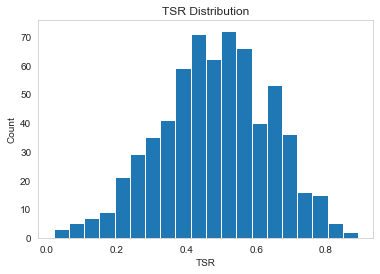

In [6]:
df.tsr.hist(bins=20)
plt.title('TSR Distribution')
plt.xlabel('TSR')
plt.ylabel('Count')
plt.grid(False)
plt.show()

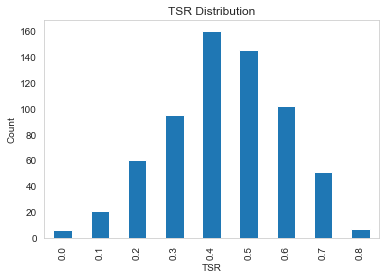

In [7]:
df.tsr_disc.value_counts().sort_index().plot.bar()
# plt.xticks(sorted(df.tsr_disc.unique()))
plt.title('TSR Distribution')
plt.xlabel('TSR')
plt.ylabel('Count')
plt.grid(False)
plt.show()

High    305
Low     342
Name: tsr_high, dtype: int64


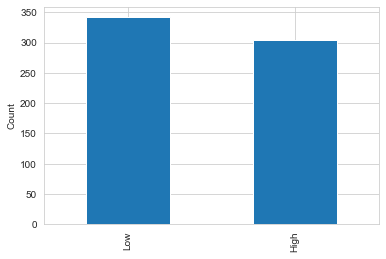

In [8]:
df['tsr_high'] = (df.tsr_disc >= 0.5).map({False:'Low', True:'High'})
print(df.tsr_high.value_counts().sort_index())
df.tsr_high.value_counts().plot.bar()
# plt.xticks([0,1],['High', 'Low'])
plt.ylabel('Count')
plt.show()

## Sidenote: Aggregation by patient

In [9]:
problems = {}
df['tsr_agg'] = 0
for id, group in df.groupby('patient_id'):
    # if (group.tsr_high != group.tsr_high.iloc[0]).any():
    #     problems[id] = {'total_samples': group.shape[0], **dict(group.tsr_high.value_counts())}
    #     df.loc[group.index, 'tsr_high'] = 'Low'
    df.loc[group.index, 'tsr_agg'] = group.tsr.mean()
    problems[id] = {'total_samples': group.shape[0], 'values': group.tsr.values}


print(f'We have {len(problems)} problems in total')

We have 340 problems in total


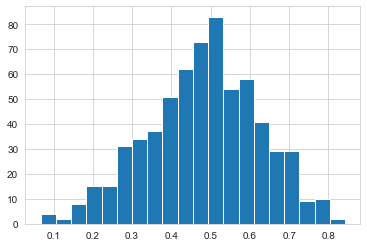

In [10]:
df.tsr_agg.hist(bins=20)
plt.show()

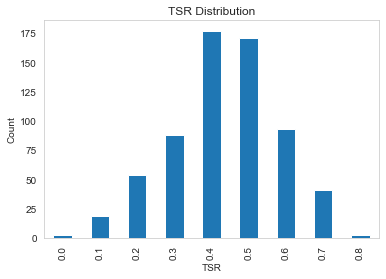

In [11]:
df['tsr_agg_disc'] = np.round(np.floor(df.tsr_agg*10)/10, decimals=1)
df.tsr_agg_disc.value_counts().sort_index().plot.bar()
# plt.xticks(sorted(df.tsr_disc.unique()))
plt.title('TSR Distribution')
plt.xlabel('TSR')
plt.ylabel('Count')
plt.grid(False)
plt.show()

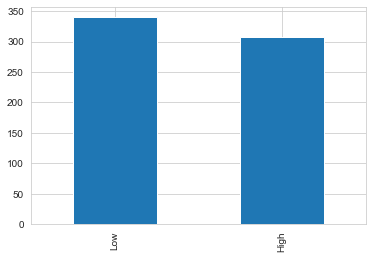

In [12]:
df['tsr_agg_high'] = (df.tsr_agg_disc >= 0.5).map({True:'High', False:'Low'})
df.tsr_agg_high.value_counts().plot.bar()
plt.show()

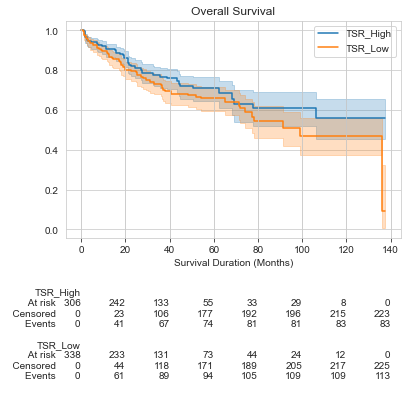

The average survival is different? p-value of 0.721 says No


In [13]:
data = df.dropna(subset=['tsr', 'os'])
model_high = KaplanMeierFitter().fit(data[data.tsr_agg_high=='High'].os, data[data.tsr_agg_high=='High'].os_event == 'dead', label='TSR_High')
model_low = KaplanMeierFitter().fit(data[data.tsr_agg_high=='Low'].os, data[data.tsr_agg_high=='Low'].os_event == 'dead', label='TSR_Low')

ax = model_high.plot()
ax = model_low.plot(ax=ax)
plt.title('Overall Survival')
plt.xlabel('Survival Duration (Months)')
add_at_risk_counts(model_high, model_low, ax=ax)
plt.show()

res = ttest_ind(data[data.tsr_high=="High"].os, data[data.tsr_high=="Low"].os)
print(f'The average survival is different? p-value of {res.pvalue:.3f} says {"Yes" if res.pvalue<=5e-2 else "No"}')

## Back to the normal stuff

In [14]:
feature_cols = ['pm', 'pn', 'pt', 'tnm', 'tbc', 'tsr']
# feature_cols = ['pn_group']
target_cols = ['os', 'os_event']

data = df[feature_cols + target_cols].dropna()
encoders = {}
for col in data:
    if isinstance(data[col].dtype, pd.CategoricalDtype):
        encoders[col] = LabelEncoder().fit(data[col])
        data[col] = encoders[col].transform(data[col])

model = CoxPHFitter()
model.fit(data, duration_col=target_cols[0], event_col=target_cols[1], show_progress=True)

model.print_summary(style='ascii')

Iteration 1: norm_delta = 0.58401, step_size = 0.9000, log_lik = -824.08620, newton_decrement = 28.44421, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.24917, step_size = 0.9000, log_lik = -797.44765, newton_decrement = 1.07505, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.02036, step_size = 0.9000, log_lik = -796.38703, newton_decrement = 0.01122, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00007, step_size = 1.0000, log_lik = -796.37578, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -796.37578, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 5 iterations.
<lifelines.CoxPHFitter: fitted with 461 total observations, 312 right-censored observations>
             duration col = 'os'
                event col = 'os_event'
      baseline estimation = breslow
   number of observations = 461
number of events observed = 149
   partial log-likelihood = -796.38
   

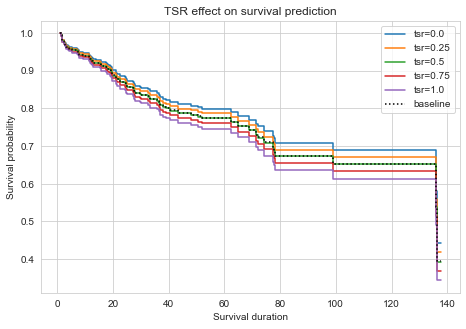

In [15]:
model.plot_partial_effects_on_outcome(['tsr'], np.linspace(0,1,5), figsize=(7.5,5))
plt.title('TSR effect on survival prediction')
plt.xlabel('Survival duration')
plt.ylabel('Survival probability')
plt.show()

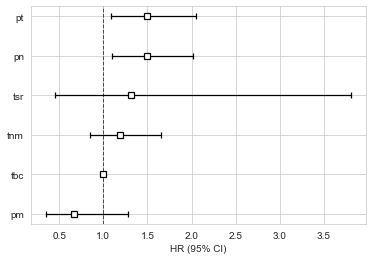

In [16]:
model.plot(hazard_ratios=True)
plt.show()

In [17]:
model.check_assumptions(data, p_value_threshold=5e-2)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 461 total observations, 312 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic      p  -log2(p)
pm  km              0.23   0.64      0.65
    rank            0.10   0.75      0.41
pn  km              0.58   0.44      1.17
    rank            0.05   0.83      0.27
pt  km              4.87   0.03      5.20
    rank            4.14   0.04      4.57
tbc km             11.65 <0.005     10.61
    rank            8.61 <0.005      8.23
tnm km              0.15   0.70      0.52
    rank            0.18   0.67      0.57
tsr km              0.06   0.80      0.32
    rank            0.00   0.97      0.04



1. Variable 'pt' failed the non-proportional test: p-value is 0.0273.

   Advice: with so few unique values (only 4), you can include `strata=['pt', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable 'tbc' failed the non-proportional test: p-value is 0.0006.

   Advice 1: the functional form of the variable 'tbc' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'tbc' using pd.cut, and then specify it in `strata=['tbc',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/

[]

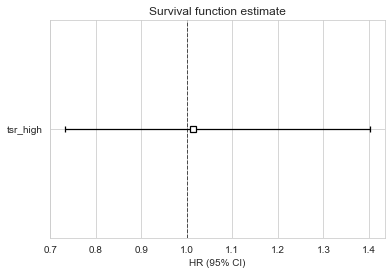

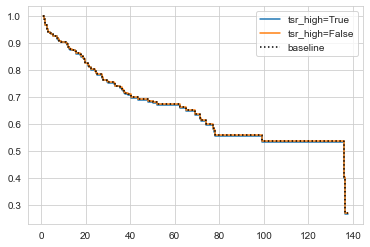

In [18]:
data['tsr_high'] = df.loc[data.index, 'tsr_high'].map({'High': True, 'Low': False})
univar_model = CoxPHFitter().fit(data[['tsr_high', 'os', 'os_event']], duration_col='os', event_col='os_event')
univar_model.plot(hazard_ratios=True)
plt.title('Survival function estimate')
plt.show()

univar_model.plot_partial_effects_on_outcome('tsr_high', values=[True, False])
plt.show()

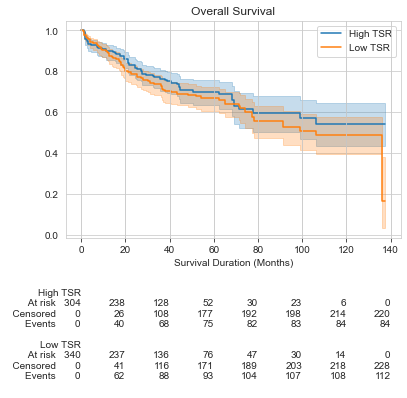

The average survival is different? p-value of 0.721 says No


In [19]:
data = df.dropna(subset=['tsr', 'os'])
model_high = KaplanMeierFitter().fit(data[data.tsr_high=='High'].os, data[data.tsr_high=='High'].os_event == 'dead')
model_low = KaplanMeierFitter().fit(data[data.tsr_high=='Low'].os, data[data.tsr_high=='Low'].os_event == 'dead')

ax = model_high.plot(label='High TSR')
ax = model_low.plot(ax=ax, label='Low TSR')
plt.title('Overall Survival')
plt.xlabel('Survival Duration (Months)')
add_at_risk_counts(model_high, model_low, labels=['High TSR', 'Low TSR'], ax=ax)
plt.show()

res = ttest_ind(data[data.tsr_high=="High"].os, data[data.tsr_high=="Low"].os)
print(f'The average survival is different? p-value of {res.pvalue:.3f} says {"Yes" if res.pvalue<=5e-2 else "No"}')

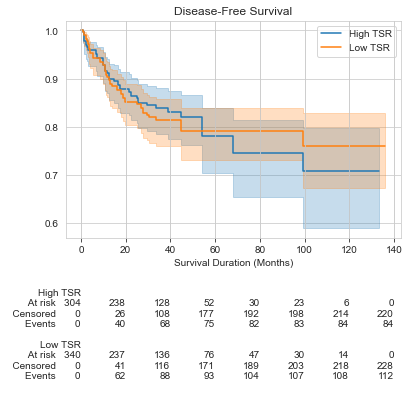

The average survival is different? p-value of 0.294 says No


In [20]:
data = df.dropna(subset=['dfs', 'tsr'])
model_free = KaplanMeierFitter().fit(data[data.tsr_high=='High'].dfs, data[data.tsr_high=='High'].dfs_event == 'recurrence')
model_recurrent = KaplanMeierFitter().fit(data[data.tsr_high=='Low'].dfs, data[data.tsr_high=='Low'].dfs_event == 'recurrence')

ax = model_free.plot(label='High TSR')
model_recurrent.plot(ax=ax, label='Low TSR')
plt.title('Disease-Free Survival')
plt.xlabel('Survival Duration (Months)')
add_at_risk_counts(model_high, model_low, labels=['High TSR', 'Low TSR'], ax=ax)
plt.show()

res = ttest_ind(data[data.tsr_high=="High"].dfs, data[data.tsr_high=="Low"].dfs)
print(f'The average survival is different? p-value of {res.pvalue:.3f} says {"Yes" if res.pvalue<=5e-2 else "No"}')

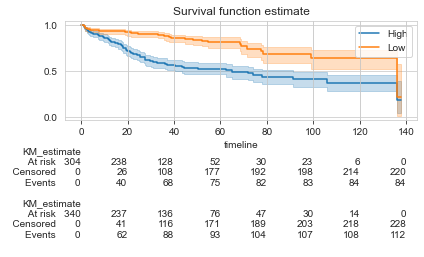

The average survival is different? p-value of 0.024 says Yes


In [21]:
data = df.dropna(subset=['os', 'pn'])
model_free = KaplanMeierFitter().fit(data[~(data.pn_group=='pn0')].os, data[~(data.pn_group=='pn0')].os_event == 'dead', label='Pn0')
model_recurrent = KaplanMeierFitter().fit(data[data.pn_group=='pn0'].os, data[data.pn_group=='pn0'].os_event == 'dead', label='Pn123')

ax = model_free.plot(label='High')
model_recurrent.plot(ax=ax, label='Low')
plt.title('Survival function estimate')
add_at_risk_counts(model_high, model_low, ax=ax)
plt.tight_layout()
plt.show()

res = ttest_ind(data[data.pn_group=='pn0'].os, data[(data.pn_group!='pn0')].os)
print(f'The average survival is different? p-value of {res.pvalue:.3f} says {"Yes" if res.pvalue<=5e-2 else "No"}')

## Acquisition Time/ TSR correlation
During the course of this project, we noticed that calculating for the first 240-ish slides yields TSR values that show a **lower** survival probability. This is contrary to established literature.
When rerunning the statistical tests for a bigger subset of the total dataset that contains later slides, we noticed that trend has reversed.
We try here to investigate the origin of that discrepancy.

In [22]:
full_df = pd.read_pickle('./metadata/bern_data.pkl')
# full_df['patient_id'] = full_df.slide_filename.map(lambda x: x.split('_')[0])
full_df['scan_year'] = full_df.slide_filename.map(lambda x: int(x.split('.')[0].split('_')[1][1:]))

full_df[['slide_filename', 'patient_id', 'scan_year']].head()

,slide_filename,patient_id,scan_year
0,003b_B2010.14359_I-D_HE.mrxs,3,2010
1,003c_B2010.14359_I-E_HE.mrxs,3,2010
4,006b_B2008.17770_I-E_HE.mrxs,6,2008
5,006c_B2008.17770_I-K_HE.mrxs,6,2008
6,006d_B2008.17770_I-G_HE.mrxs,6,2008


In [23]:
# full_df['patient_id'] = LabelEncoder().fit_transform(full_df.patient_id)
full_df[['patient_id', 'scan_year', 'os', 'tsr_est_mean']].dropna().corr()

,patient_id,scan_year,os,tsr_est_mean
patient_id,1.000000,0.829582,-0.399196,-0.141106
scan_year,0.829582,1.000000,-0.534617,-0.124210
os,-0.399196,-0.534617,1.000000,0.113474
tsr_est_mean,-0.141106,-0.124210,0.113474,1.000000


In [24]:
corr_data = df[['tsr', 'tsr_high', 'tsr_disc']].dropna()
corr_data['patient_id'] = full_df.loc[data.index, 'patient_id']
corr_data['scan_year'] = full_df.loc[data.index, 'scan_year']

corr_data.head()

,tsr,tsr_high,tsr_disc,patient_id,scan_year
0,0.760542,High,0.7,3.0,2010.0
1,0.701752,High,0.7,3.0,2010.0
4,0.209621,Low,0.2,6.0,2008.0
5,0.272062,Low,0.2,6.0,2008.0
6,0.102042,Low,0.1,6.0,2008.0


In [25]:
# data['patient_id'] = LabelEncoder().fit_transform(data.patient_id)
corr_data.corr()

,tsr,tsr_disc,patient_id,scan_year
tsr,1.000000,0.983833,0.039947,0.064630
tsr_disc,0.983833,1.000000,0.034788,0.059851
patient_id,0.039947,0.034788,1.000000,0.828419
scan_year,0.064630,0.059851,0.828419,1.000000


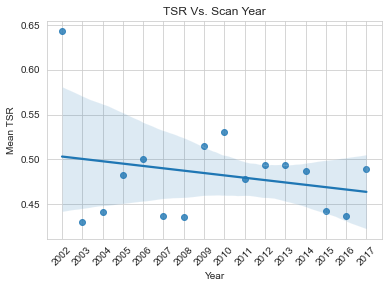

Correlation coefficient: -0.23565076753325354


In [26]:
years = []
mean_tsrs = []
nb_obs = []
for year, group in corr_data.groupby('scan_year', dropna=True):
    mean_tsrs.append(group.tsr.mean())
    years.append(year)
    nb_obs.append(group.shape[0])
# sns.lineplot(x=years, y=mean_tsrs)
sns.regplot(x=years, y=mean_tsrs)
# plt.plot(years, mean_tsrs)
plt.xticks(years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Mean TSR')
plt.title('TSR Vs. Scan Year')

plt.show()

# sns.barplot(x=years, y=nb_obs)
# plt.xticks(rotation=45)
# plt.show()

print(f'Correlation coefficient: {np.corrcoef(years, mean_tsrs)[0,1]}')

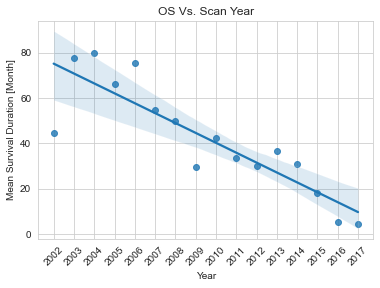

Correlation coefficient: -0.8736636290838559


In [27]:
years = []
mean_oss = []
for year, group in full_df.groupby('scan_year', dropna=True):
    mean_oss.append(group.os.mean())
    years.append(year)

# sns.lineplot(x=years, y=mean_tsrs)
sns.regplot(x=years, y=mean_oss)
# plt.plot(years, mean_tsrs)
plt.xticks(years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Mean Survival Duration [Month]')
plt.title('OS Vs. Scan Year')

plt.show()

print(f'Correlation coefficient: {np.corrcoef(years, mean_oss)[0,1]}')

Of course! The **observed** survival duration goes lower as the recorded start passes?

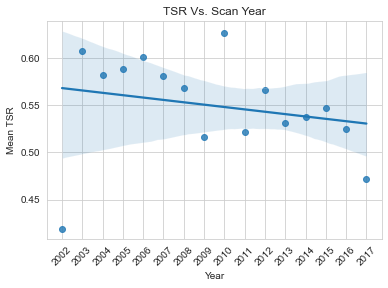

Correlation coefficient: -0.2256284316798012


In [28]:
years = []
mean_tsrs = []
for year, group in full_df.loc[corr_data.index,:].groupby('scan_year', dropna=True):
    mean_tsrs.append(group.tsr_est_mean.mean())
    years.append(year)

# sns.lineplot(x=years, y=mean_tsrs)
sns.regplot(x=years, y=mean_tsrs)
# plt.plot(years, mean_tsrs)
plt.xticks(years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Mean TSR')
plt.title('TSR Vs. Scan Year')

plt.show()

print(f'Correlation coefficient: {np.corrcoef(years, mean_tsrs)[0,1]}')

Correlation coef is 0.356


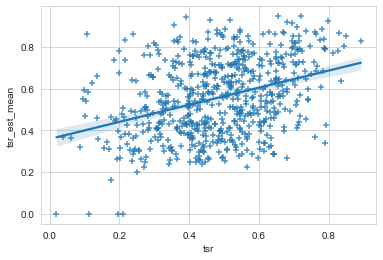

In [29]:
sns.regplot(data=df, x='tsr', y='tsr_est_mean', marker='+')
print(f'Correlation coef is {np.corrcoef(df.tsr, df.tsr_est_mean)[0,1]:.3f}')
plt.show()

## Visualize TSRs calculated within an ROI defined following pathological standards

In [9]:
roi_tsr = pd.read_csv(os.path.join(Abed_utils.OUTPUT_ROOT, 'roi_final_act_4_classified.csv'), index_col='Unnamed: 0', )
# roi_tsr = pd.read_csv(os.path.join(Abed_utils.OUTPUT_ROOT, 'ROI_detection_final_classified.csv'), index_col='Unnamed: 0', )
roi_tsr.columns = ['roi_tsr']
roi_tsr.head()

,roi_tsr
406c_B2012.31822_E_HE.mrxs,0.340608
121c_B2006.23212_III-U_HE.mrxs,0.243859
864_B2014.52476_E_HE.mrxs,0.330406
299b_B2003.19347_G_HE.mrxs,0.319476
833_B2014.40600_E_HE.mrxs,0.335107


In [10]:
roi_df = df.join(roi_tsr, on='slide_filename')
roi_df[['slide_filename', 'tsr', 'roi_tsr']].head()

,slide_filename,tsr,roi_tsr
0,003b_B2010.14359_I-D_HE.mrxs,0.760542,0.752743
1,003c_B2010.14359_I-E_HE.mrxs,0.701752,0.543471
4,006b_B2008.17770_I-E_HE.mrxs,0.209621,0.538775
5,006c_B2008.17770_I-K_HE.mrxs,0.272062,0.133610
6,006d_B2008.17770_I-G_HE.mrxs,0.102042,0.095680


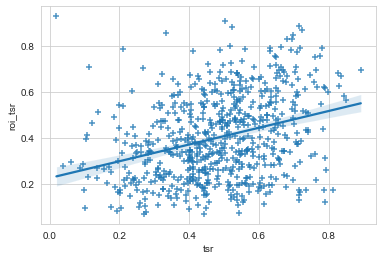

Correlation coef is 0.356


In [32]:
sns.regplot(data=roi_df, x='tsr', y='roi_tsr', marker='+')
plt.show()
print(f'Correlation coef is {np.corrcoef(df.tsr, df.tsr_est_mean)[0,1]:.3f}')

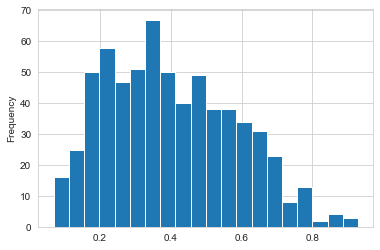

In [33]:
roi_df.roi_tsr.plot.hist(bins=20)
plt.show()

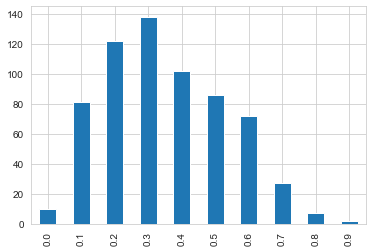

In [34]:
roi_df['roi_tsr_disc'] = np.round(np.floor(roi_df.roi_tsr * 10) / 10, decimals=1)
roi_df.roi_tsr_disc.value_counts().sort_index().plot.bar()
plt.show()
# df.roi_tsr_disc.value_counts()

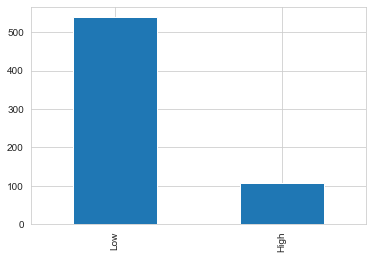

In [35]:
roi_df['roi_tsr_high'] = (roi_df.roi_tsr_disc > 0.5).map({True:'High', False:'Low'})
roi_df.roi_tsr_high.value_counts().plot.bar()
plt.show()

In [36]:
problems_roi = {}
roi_df['roi_tsr_high_norm'] = None
for id, group in roi_df.groupby('patient_id'):
    if (group.roi_tsr_high != group.roi_tsr_high.iloc[0]).any():
        problems_roi[id] = {'total_samples': group.shape[0], **dict(group.roi_tsr_high.value_counts())}
        roi_df.loc[group.index, 'tsr_high'] = 'Low'
    else:
        roi_df.loc[group.index, 'roi_tsr_high_norm'] = group.roi_tsr_high


print(f'We have {len(problems_roi)} problems in total')

We have 66 problems in total


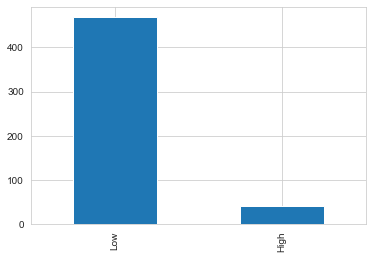

In [37]:
roi_df.roi_tsr_high_norm.value_counts().plot.bar()
plt.show()

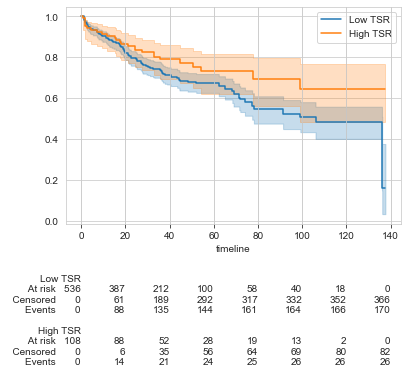

The average survival is different? p-value of 0.021 says Yes


In [38]:
data = roi_df.dropna(subset=['os'])
model_low = KaplanMeierFitter().fit(data[data.roi_tsr_high == 'Low'].os, data[data.roi_tsr_high == 'Low'].os_event == 'dead', label='Low TSR')
model_high = KaplanMeierFitter().fit(data[data.roi_tsr_high == 'High'].os, data[data.roi_tsr_high == 'High'].os_event == 'dead', label='High TSR')

ax = model_low.plot()
model_high.plot(ax=ax)
add_at_risk_counts(model_low, model_high, ax=ax)
plt.show()

res = ttest_ind(data[data.roi_tsr_high=="High"].os, data[data.roi_tsr_high=="Low"].os)
print(f'The average survival is different? p-value of {res.pvalue:.3f} says {"Yes" if res.pvalue<=5e-2 else "No"}')

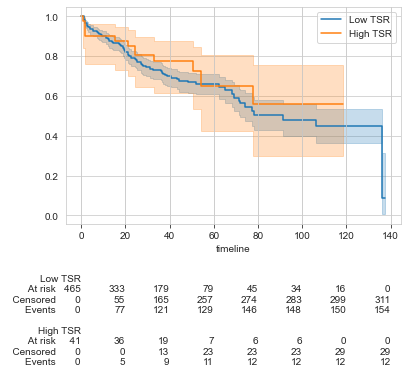

The average survival is different? p-value of 0.124 says No


In [39]:
data = roi_df.dropna(subset=['os'])
model_low = KaplanMeierFitter().fit(data[data.roi_tsr_high_norm == 'Low'].os, data[data.roi_tsr_high_norm == 'Low'].os_event == 'dead', label='Low TSR')
model_high = KaplanMeierFitter().fit(data[data.roi_tsr_high_norm == 'High'].os, data[data.roi_tsr_high_norm == 'High'].os_event == 'dead', label='High TSR')

ax = model_low.plot()
model_high.plot(ax=ax)
add_at_risk_counts(model_low, model_high, ax=ax)
plt.show()

res = ttest_ind(data[data.roi_tsr_high_norm=="High"].os, data[data.roi_tsr_high_norm=="Low"].os)
print(f'The average survival is different? p-value of {res.pvalue:.3f} says {"Yes" if res.pvalue<=5e-2 else "No"}')

## Comparison with JB's work

In [40]:
jb_df = pd.read_csv('./metadata/tsr_jonatan.csv', usecols=['tsr', 'slide_path'])
jb_df = jb_df.set_index(jb_df.slide_path).drop('slide_path', axis=1)
jb_df.head()

,tsr
slide_path,
/mnt/data/dataset/bern_cohort_clean/1/001b_B2005.30530_C_HE.mrxs,0.294270
/mnt/data/dataset/bern_cohort_clean/1/001c_B2005.30530_L_HE.mrxs,0.244243
/mnt/data/dataset/bern_cohort_clean/3/003b_B2010.14359_I-D_HE.mrxs,0.732267
/mnt/data/dataset/bern_cohort_clean/3/003c_B2010.14359_I-E_HE.mrxs,0.688844
/mnt/data/dataset/bern_cohort_clean/6/006b_B2008.17770_I-E_HE.mrxs,0.172296


Correlation coef is 0.880


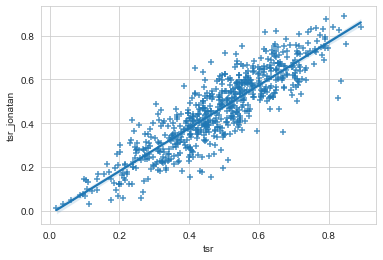

In [41]:
if 'tsr_jonatan' not in df.columns:
    df = df.join(jb_df, on='slide_path', rsuffix='_jonatan')
sns.regplot(data=df, x='tsr', y='tsr_jonatan', marker='+')
print(f'Correlation coef is {np.corrcoef(df.tsr, df.tsr_jonatan)[0,1]:.3f}')
plt.show()

In [42]:
df['tsr_diff'] = (df.tsr - df.tsr_jonatan).abs()
diff = df[['slide_filename', 'tsr_diff']].set_index(df.slide_filename, drop=True).drop('slide_filename', axis=1).squeeze().sort_values(ascending=False)
diff.head(10)

slide_filename
833_B2014.40600_F_HE.mrxs          0.309456
819_B2014.32601_D_HE.mrxs          0.309132
606c_B2013.14706_E_HE.mrxs         0.308289
409c_B2009.27229_I-P_HE.mrxs       0.304139
320b_B2004.11515_III-C_HE.mrxs     0.281341
356c_B2011.4384_I-A-Neu_HE.mrxs    0.258857
353c_B2008.16976_II-E_HE.mrxs      0.247594
299b_B2003.19347_G_HE.mrxs         0.245545
034c_B2004.10048_IV-D_HE.mrxs      0.240334
598c_B2012.7967_F_HE.mrxs          0.236572
Name: tsr_diff, dtype: float64

In [43]:
JB_PATH = "D:/self_supervised_pathology/jb_results/results_ws"
def wsi_name_to_jb_result(filename:str):
    return os.path.join(JB_PATH, os.path.splitext(filename)[0] + '.npy')

def wsi_name_to_aas_result(filename:str):
    return os.path.join(Abed_utils.OUTPUT_ROOT, 'predictions_KNN', filename+'_seg_dino_imagenet_100ep_KNN.npy')

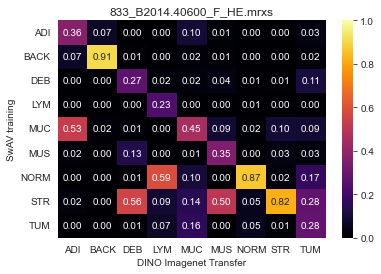

In [44]:
filename = diff.index[0]

my_preds = np.load(wsi_name_to_aas_result(filename), allow_pickle=True).item()['classification']
jb_preds = np.load(wsi_name_to_jb_result(filename), allow_pickle=True).item()['classification'].argmax(axis=1)
labels = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
conf = confusion_matrix(jb_preds, my_preds, normalize='pred')

sns.heatmap(conf, xticklabels=labels, yticklabels=labels, cmap='inferno', annot=True, fmt='.2f', vmin=0, vmax=1)
plt.xlabel('DINO Imagenet Transfer')
plt.ylabel('SwAV training')
plt.title(filename)
plt.show()

## Aggregating by patient

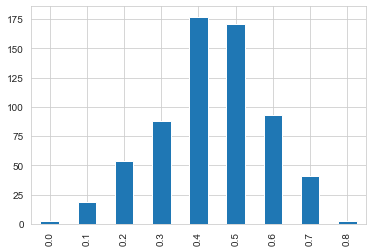

In [87]:
clean_tsr = df[['patient_id', 'tsr', 'os', 'os_event']].groupby('patient_id').mean()
clean_tsr = clean_tsr.merge(df[['os_event', 'patient_id']], right_on='patient_id', left_index=True)
clean_tsr['tsr_disc'] = np.round(np.floor(10 * clean_tsr.tsr)/10, decimals=1)
clean_tsr.tsr_disc.value_counts().sort_index().plot.bar()
plt.show()

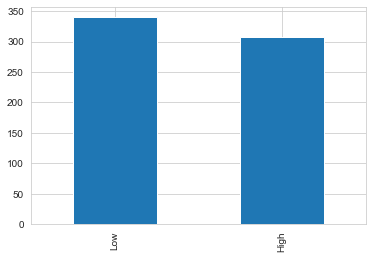

In [88]:
clean_tsr['tsr_high'] = (clean_tsr.tsr_disc >= 0.5).map({True:'High', False:'Low'})
clean_tsr.tsr_high.value_counts().plot.bar()
plt.show()

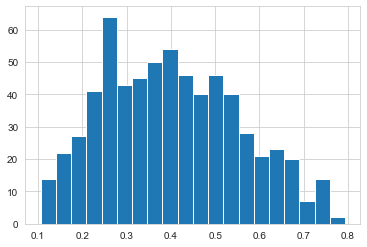

In [76]:
roi_df_agg = roi_df[['roi_tsr', 'os', 'patient_id']].groupby('patient_id').agg('mean')
roi_df_agg = roi_df_agg.merge(roi_df[['os_event', 'patient_id']], right_on='patient_id', left_index=True)
roi_df_agg.roi_tsr.hist(bins=20)
plt.show()

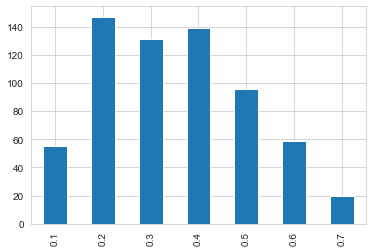

In [80]:
roi_df_agg['roi_tsr_disc'] = np.round(np.floor(roi_df_agg.roi_tsr*10)/10, decimals=1)
roi_df_agg.roi_tsr_disc.value_counts().sort_index().plot.bar()
plt.show()

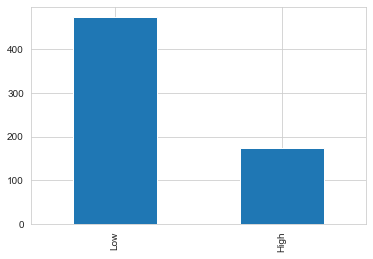

In [81]:
roi_df_agg['roi_tsr_high'] = (roi_df_agg.roi_tsr_disc >= 0.5).map({True:'High', False:'Low'})
roi_df_agg.roi_tsr_high.value_counts().plot.bar()
plt.show()

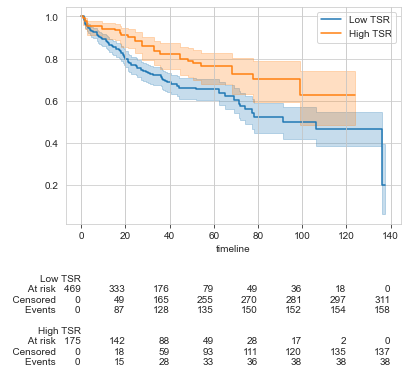

The average survival is different? p-value of 0.002 says Yes


In [94]:
data = roi_df_agg.dropna(subset=['os']).copy()
# data['os_event'] = roi_df.loc[data.index, 'os_event']
model_low = KaplanMeierFitter().fit(data[data.roi_tsr_high == 'Low'].os, data[data.roi_tsr_high == 'Low'].os_event == 'dead', label='Low TSR')
model_high = KaplanMeierFitter().fit(data[data.roi_tsr_high == 'High'].os, data[data.roi_tsr_high == 'High'].os_event == 'dead', label='High TSR')

ax = model_low.plot()
model_high.plot(ax=ax)
add_at_risk_counts(model_low, model_high, ax=ax)
plt.show()

res = ttest_ind(data[data.roi_tsr_high=="High"].os, data[data.roi_tsr_high=="Low"].os)
print(f'The average survival is different? p-value of {res.pvalue:.3f} says {"Yes" if res.pvalue<=5e-2 else "No"}')

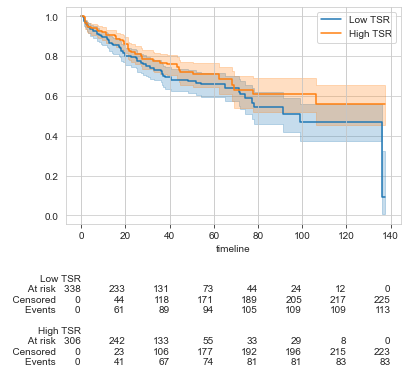

The average survival is different? p-value of 0.519 says No


In [90]:
data = clean_tsr.dropna(subset=['os']).copy()
# data['os_event'] = roi_df.loc[data.index, 'os_event']
model_low = KaplanMeierFitter().fit(data[data.tsr_high == 'Low'].os, data[data.tsr_high == 'Low'].os_event == 'dead', label='Low TSR')
model_high = KaplanMeierFitter().fit(data[data.tsr_high == 'High'].os, data[data.tsr_high == 'High'].os_event == 'dead', label='High TSR')

ax = model_low.plot()
model_high.plot(ax=ax)
add_at_risk_counts(model_low, model_high, ax=ax)
plt.show()

res = ttest_ind(data[data.tsr_high=="High"].os, data[data.tsr_high=="Low"].os)
print(f'The average survival is different? p-value of {res.pvalue:.3f} says {"Yes" if res.pvalue<=5e-2 else "No"}')

In [106]:
data = roi_df_agg[['os', 'os_event', 'roi_tsr_high']].dropna()
data ['os_event'] = data.os_event.map({'alive': False, 'dead': True})
data['roi_tsr_high'] = data.roi_tsr_high.map({'Low': 1, 'High':0})
data = data.merge(df[['pn_group', 'pt_group', 'patient_id']], right_on='patient_id', left_index=True)
data[['pn_group', 'pt_group']] = LabelEncoder().
reg = CoxPHFitter().fit(data, duration_col='os', event_col='os_event')
reg.print_summary(style='ascii')

ValueError: Cannot cast object dtype to float64

In [101]:
data.dtypes

roi_tsr          float64
os               float64
os_event        category
patient_id         int64
roi_tsr_disc     float64
roi_tsr_high       int64
dtype: object

## SAVE

In [91]:
clean_tsr.to_csv('metadata/tsr_wsi_agg.csv')
roi_df_agg.to_csv('metadata/tsr_roi_agg.csv')

In [112]:
full_df = pd.read_pickle('metadata/bern_data.pkl')
full_df = full_df.join(tsr, on='slide_filename')
full_df = full_df.join(roi_tsr, on='slide_filename')
full_df.head()


,patient_id,gender,age,diagnosis,location_specific,location,pt,pt_group,pn,pn_group,...,tsr_q25,tsr_q50,tsr_q75,tsr_mean,tsr_est_q25,tsr_est_q50,tsr_est_q75,tsr_est_mean,tsr,roi_tsr
0,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,pn0,...,0.936087,0.976751,0.990994,0.955028,0.824026,0.876453,0.924482,0.872773,0.760542,0.752743
1,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,pn0,...,0.940220,0.971893,0.986070,0.930820,0.771250,0.823717,0.877430,0.820560,0.701752,0.543471
4,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,0.022578,0.054593,0.540306,0.279577,0.394779,0.487238,0.608896,0.509430,0.209621,0.538775
5,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,0.063587,0.150189,0.607203,0.332216,0.457595,0.509831,0.598535,0.512643,0.272062,0.133610
6,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,0.017364,0.042972,0.115521,0.130877,0.419876,0.474648,0.515490,0.466747,0.102042,0.095680


In [113]:
fig, axs = plt.subplots(1, 2, figsize=(10,8))
